# Image classifier using a CNN

This notebook is a simple example of how to use a Convolutional Neural Network (CNN) to classify images. The dataset used is the CIFAR-10 dataset, which consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [111]:
tansform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=tansform)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

test_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=tansform)

test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


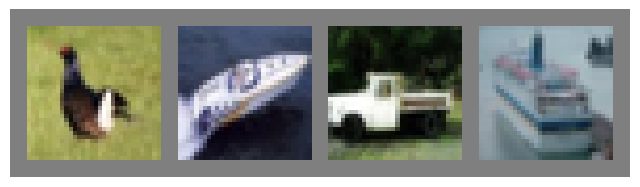

 bird  ship truck  ship


In [112]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')
    plt.show()


images, labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(images[:4], padding=4, scale_each=True))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [113]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = nn.Flatten()(x)   
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

print(model)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [114]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [115]:
def train(model, loader, loss_fn, optimizer):
    size = len(loader.dataset)
    model.train()
    
    for batch, (x, y) in enumerate(loader):
        inputs, labels = x.to(device), y.to(device)

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(inputs)
            print(f'[{current:>5d}/{size:>5d}] loss: {loss:>7f}')


def test(model, loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for x, y in loader:
            inputs, labels = x.to(device), y.to(device)
            outputs = model(inputs)
            test_loss += loss_fn(outputs, labels).item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(loader.dataset)
    test_accuracy = 100. * correct / len(loader.dataset)
    print(f'\nAverage loss: {test_loss}, Accuracy: {test_accuracy}%\n')

In [116]:
epochs = 10

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}\n' + '-' * 35 + '\n')
    train(model, train_loader, loss_fn, optimizer)
    test(model, test_loader, loss_fn)

print('Done!')

Epoch 1
-----------------------------------

[    0/50000] loss: 2.298599
[10000/50000] loss: 2.296345
[20000/50000] loss: 2.309300
[30000/50000] loss: 2.305393
[40000/50000] loss: 2.304018

Average loss: 0.023000881028175355, Accuracy: 10.4%

Epoch 2
-----------------------------------

[    0/50000] loss: 2.299791
[10000/50000] loss: 2.296515
[20000/50000] loss: 2.296494
[30000/50000] loss: 2.291609
[40000/50000] loss: 2.289054

Average loss: 0.02284361619949341, Accuracy: 17.05%

Epoch 3
-----------------------------------

[    0/50000] loss: 2.282311
[10000/50000] loss: 2.269842
[20000/50000] loss: 2.254164
[30000/50000] loss: 2.214095
[40000/50000] loss: 2.209249

Average loss: 0.020722372961044313, Accuracy: 24.49%

Epoch 4
-----------------------------------

[    0/50000] loss: 2.104902
[10000/50000] loss: 2.095367
[20000/50000] loss: 1.984151
[30000/50000] loss: 2.093236
[40000/50000] loss: 1.950942

Average loss: 0.018770077335834502, Accuracy: 31.24%

Epoch 5
--------------

Let's see how the model performs on some examples.

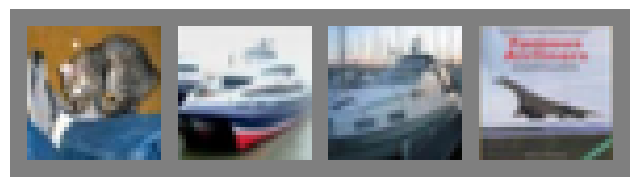

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship   car  ship


In [117]:
test_data_iter = iter(test_loader)

images, labels = next(test_data_iter)

imshow(torchvision.utils.make_grid(images[:4], padding=4, scale_each=True))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

model.eval()
outputs = model(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [118]:
class_correct = {classname: 0 for classname in classes}
class_total = {classname: 0 for classname in classes}

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        inputs, labels = x.to(device), y.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                class_correct[classes[label]] += 1
            class_total[classes[label]] += 1

for classname, correct_count in class_correct.items():
    accuracy = 100 * float(correct_count) / class_total[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 44.7 %
Accuracy for class: car   is 67.3 %
Accuracy for class: bird  is 25.8 %
Accuracy for class: cat   is 21.3 %
Accuracy for class: deer  is 35.7 %
Accuracy for class: dog   is 41.7 %
Accuracy for class: frog  is 62.5 %
Accuracy for class: horse is 65.8 %
Accuracy for class: ship  is 60.7 %
Accuracy for class: truck is 54.7 %
